# **1 Задание**

### Условие
Используя уравнение Шрёдингера, найти связанные состояния и соответствующие им собственные значения для потенциальной ямы произвольной формы, заданной аналитически или таблично функцией (U(x)) в диапазоне от (0) до (a), где (a) — ширина ямы. Построить графики собственных функций

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

In [2]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12

In [3]:
# Функция решения одномерного стационарного уравнения Шрёдингера для произвольного потенциала
# H ψ = E ψ на отрезке [0, a] с граничными условиями ψ(0)=ψ(a)=0
def solve_schrodinger_1d(x, Ux, mass=1.0, hbar=1.0, num_states=5):
    """
    Решает одномерное стационарное уравнение Шрёдингера:
    - (ħ^2 / 2m) d^2ψ/dx^2 + U(x) ψ = E ψ; на сетке x с граничными условиями ψ(0)=ψ(a)=0
    """

    x = np.asarray(x)
    Ux = np.asarray(Ux)

    N = x.size
    if Ux.size != N:
        raise ValueError("Ux должен иметь ту же длину, что и x")

    dx = x[1] - x[0]
    if not np.allclose(np.diff(x), dx, rtol=1e-6, atol=1e-10):
        raise ValueError("Сетка x должна быть равномерной")

    x_in = x[1:-1]
    U_in = Ux[1:-1]
    n_in = x_in.size

    if num_states >= n_in:
        raise ValueError("num_states должен быть меньше количества внутренних точек сетки")

    main_diag_T = (hbar**2) / (mass * dx**2) * np.ones(n_in)
    off_diag_T = -(hbar**2) / (2.0 * mass * dx**2) * np.ones(n_in - 1)

    T = diags(
        diagonals=[off_diag_T, main_diag_T, off_diag_T],
        offsets=[-1, 0, 1],
        format='csr'
    )

    V = diags(U_in, 0, format='csr')

    H = T + V

    evals, evecs = eigsh(H, k=num_states, which='SA')

    idx_sort = np.argsort(evals)
    evals = evals[idx_sort]
    evecs = evecs[:, idx_sort]

    wavefuncs = np.zeros((num_states, N))

    for n in range(num_states):
        psi_in = evecs[:, n]

        norm = np.sqrt(np.trapezoid(np.abs(psi_in)**2, x_in))
        psi_in /= norm

        wavefuncs[n, 1:-1] = psi_in

    return evals, wavefuncs


In [4]:
# Функции для задания потенциала
def potential_analytic(x):
    """
    Произвольная аналитическая потенциальная яма на [0, a]
    - В середине яма (от a/3 до 2a/3) с глубиной -U_0
    - Cнаружи потенциал 0
    Отрезок [0, a] задаётся сеткой x с min(x)=0 max(x)=a
    """

    x = np.asarray(x)
    a = x.max() - x.min()
    U0 = 50.0

    U = np.zeros_like(x)

    mask_well = (x >= a / 3) & (x <= 2 * a / 3)
    U[mask_well] = -U0

    return U

In [5]:
# Параметры области и сетки
a = 1.0
N = 1000
x = np.linspace(0.0, a, N)

# Задаём потенциал аналитически
U_analytic = potential_analytic(x)

# Решаем уравнение Шрёдингера
mass = 1.0
hbar = 1.0
num_states = 5

energies, wavefuncs = solve_schrodinger_1d(
    x=x,
    Ux=U_analytic,
    mass=mass,
    hbar=hbar,
    num_states=num_states
)

print("Собственные значения (энергии)")
for i, E in enumerate(energies):
    print(f"n = {i}, E_n = {E:.6f}")

Собственные значения (энергии)
n = 0, E_n = -33.448205
n = 1, E_n = 4.706419
n = 2, E_n = 33.806875
n = 3, E_n = 60.462049
n = 4, E_n = 108.743267


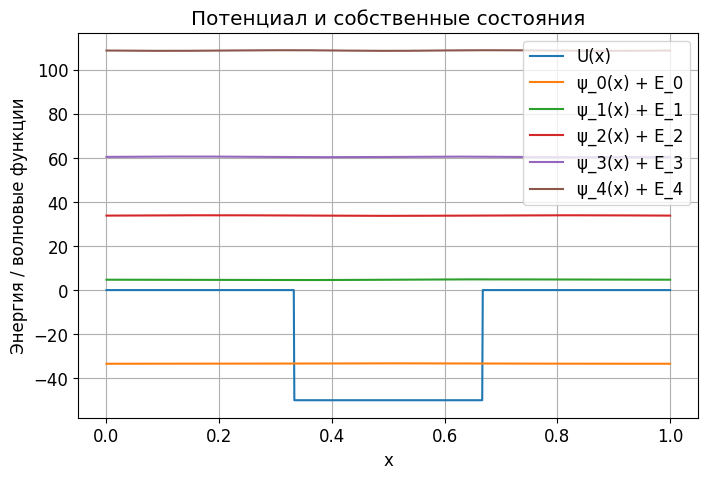

In [6]:
# Визуализация потенциала и собственных функций
def plot_potential_and_states(x, Ux, energies, wavefuncs, scale_factor=0.1):
    plt.figure()

    plt.plot(x, Ux, label="U(x)")

    for n, (E, psi) in enumerate(zip(energies, wavefuncs)):
        plt.plot(x, scale_factor * psi + E, label=f"ψ_{n}(x) + E_{n}")

    plt.xlabel("x")
    plt.ylabel("Энергия / волновые функции")
    plt.title("Потенциал и собственные состояния")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_potential_and_states(x, U_analytic, energies, wavefuncs, scale_factor=0.1)

# 2 Задание

## Условие
Для потенциального барьера произвольной формы, заданного аналитически или таблично функцией (U(x) > 0) в диапазоне от (0) до (h), где (h) — ширина барьера, определить вероятность прохождения частицы через такой барьер при заданных энергии (E) и массе (m)

In [7]:
# Аналитический пример потенциального барьера на [0, h]
# Аналогично тому, как мы задавали яму, только теперь U(x) > 0
def barrier_potential_analytic(x):
    """
    - В центре барьер (от h/3 до 2h/3) высотой +U0,
    - Снаружи (до 0 и после h) потенциал 0.
    Отрезок [0, h] задаётся сеткой x с min(x)=0, max(x)=h.
    """
    
    x = np.asarray(x)
    h = x.max() - x.min()
    U0 = 50.0

    U = np.zeros_like(x)
    mask_barrier = (x >= h / 3) & (x <= 2 * h / 3)
    U[mask_barrier] = U0

    return U


In [8]:
# WKB-приближение для вероятности туннельного прохода через барьер
# T ≈ exp( -2 ∫ κ(x) dx ),
# где κ(x) = sqrt(2m (U(x) - E)) / ħ в той области, где U(x) > E
# Это приближение хорошо работает, когда барьер достаточно плавный/широкий
def transmission_wkb(x, Ux, E, mass=1.0, hbar=1.0):
    """
    Оценивает вероятность прохождения частицы через барьер U(x) при энергии E в WKB-приближении
    """

    x = np.asarray(x)
    Ux = np.asarray(Ux)

    if Ux.size != x.size:
        raise ValueError("Ux должен иметь ту же длину, что и x")

    forbidden_mask = Ux > E

    if not np.any(forbidden_mask):
        return 1.0

    x_forbidden = x[forbidden_mask]
    U_forbidden = Ux[forbidden_mask]

    kappa = np.sqrt(2.0 * mass * (U_forbidden - E)) / hbar

    S = np.trapezoid(kappa, x_forbidden)

    T = np.exp(-2.0 * S)

    T = float(np.clip(T, 0.0, 1.0))

    return T

In [9]:
# Параметры области и сетки
h = 1.0
N_barrier = 1000
x_barrier = np.linspace(0.0, h, N_barrier)

U_barrier = barrier_potential_analytic(x_barrier)

mass_barrier = 1.0
hbar_barrier = 1.0

# Энергия частицы (возьмём меньше высоты барьера, чтобы был туннельный режим)
E = 10.0

T_wkb = transmission_wkb(
    x=x_barrier,
    Ux=U_barrier,
    E=E,
    mass=mass_barrier,
    hbar=hbar_barrier
)

print(f"Энергия частицы: E = {E}")
print(f"Вероятность прохождения через барьер (WKB): T ≈ {T_wkb:.3e}")

Энергия частицы: E = 10.0
Вероятность прохождения через барьер (WKB): T ≈ 2.573e-03


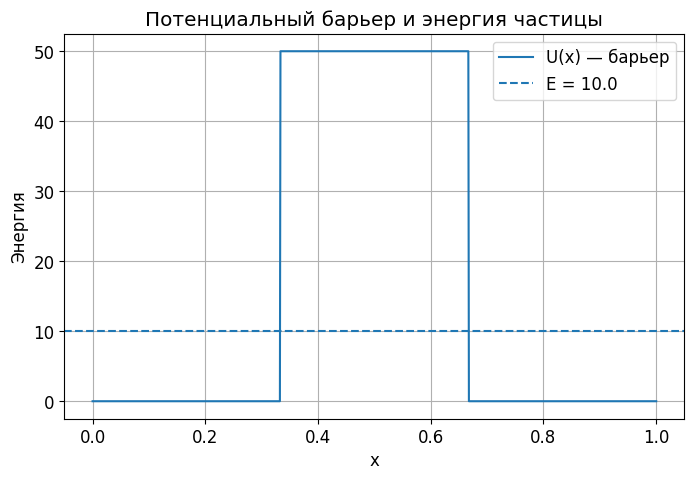

In [10]:
plt.figure()

plt.plot(x_barrier, U_barrier, label="U(x) — барьер")
plt.axhline(E, linestyle='--', label=f"E = {E}")

plt.xlabel("x")
plt.ylabel("Энергия")
plt.title("Потенциальный барьер и энергия частицы")
plt.legend()
plt.grid(True)
plt.show()